In [1]:
# Real life data

import logging
import json
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.aggregate import (Minimum, Mean, Maximum)
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, HistogramAggregator)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [18]:
'''
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())


db_schema=None           
fm = FileModelStore()
db = Database(credentials=credentials) # , model_store=fm)
print (db)
'''
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-09-03T13:56:20.715 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [19]:
df_input = pd.read_csv('iot_vacuum_rawHouseAir.csv', parse_dates=['rcv_timestamp_utc'])
df_input2 = pd.read_csv('dm_vacuum_KMeanScore.csv', parse_dates=['timestamp'])
df_input['timestamp'] = df_input['rcv_timestamp_utc']
df_input['score'] = df_input2['value_n']
df_input = df_input.dropna()
df_input = df_input.set_index(['timestamp']).sort_index()

df_input = df_input[['houseair','score']]
df_input
df_snippet = df_input.head(370)

<AxesSubplot:xlabel='timestamp'>

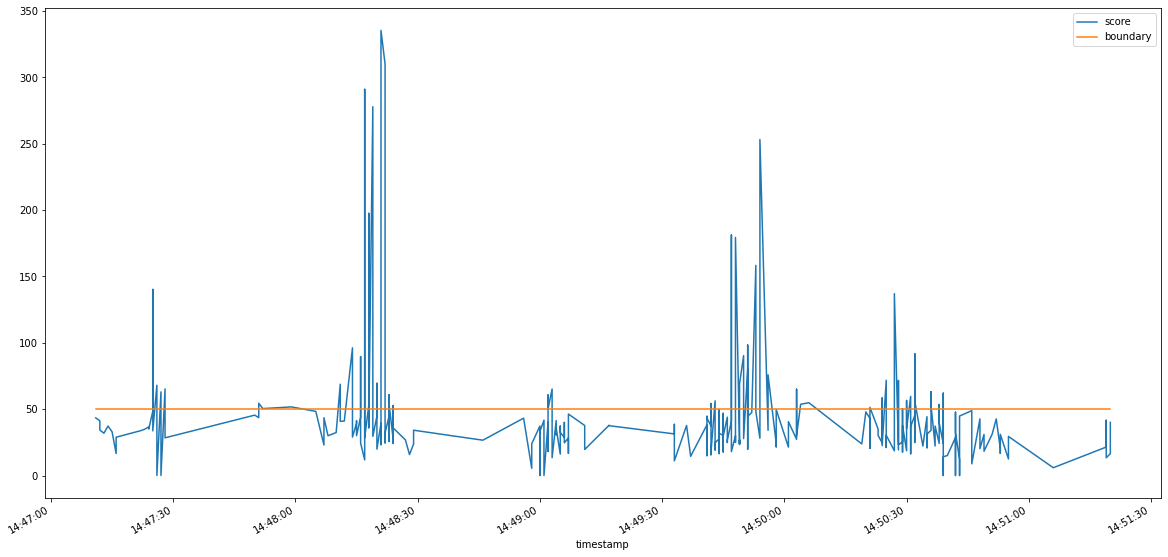

In [20]:
df_snippet['boundary'] = 50
df_snippet[['score','boundary']].plot(figsize=(20,10))

In [21]:
df_input['entity'] = 'MyRoom'
df_input = df_input.reset_index().set_index(['entity','timestamp'])

In [22]:
df_input.reset_index()

,entity,timestamp,houseair,score
0,MyRoom,2020-04-08 14:47:11,96.830549,43.422370
1,MyRoom,2020-04-08 14:47:12,98.578882,41.174747
2,MyRoom,2020-04-08 14:47:12,96.481989,34.242996
3,MyRoom,2020-04-08 14:47:13,95.956382,31.865686
4,MyRoom,2020-04-08 14:47:14,97.140380,37.262580
...,...,...,...,...
581,MyRoom,2020-04-08 14:53:05,94.617469,39.894424
582,MyRoom,2020-04-08 14:53:05,95.707411,31.156020
583,MyRoom,2020-04-08 14:53:06,99.840338,31.882555
584,MyRoom,2020-04-08 14:53:06,98.916377,35.073260


In [25]:
df_input2 = df_input.copy()

Indexlist = df_input2.index.to_list()
Indexlist_new = []
for p in Indexlist:
    p_new = ('MyRoom2', p[1])
    Indexlist_new.append(p_new)
df_input2.index = Indexlist_new
df_input = pd.concat([df_input,df_input2])
df_input


houseair      score
entity  timestamp                                
MyRoom  2020-04-08 14:47:11  96.830549  43.422370
        2020-04-08 14:47:12  98.578882  41.174747
        2020-04-08 14:47:12  96.481989  34.242996
        2020-04-08 14:47:13  95.956382  31.865686
        2020-04-08 14:47:14  97.140380  37.262580
...                                ...        ...
MyRoom2 2020-04-08 14:53:05  94.617469  39.894424
        2020-04-08 14:53:05  95.707411  31.156020
        2020-04-08 14:53:06  99.840338  31.882555
        2020-04-08 14:53:06  98.916377  35.073260
        2020-04-08 14:53:07  96.454325  34.824245

[1172 rows x 2 columns]

In [26]:
from mmfunctions.bif import (AggregateWithExpression, AggregateTimeInState)



In [27]:
df_input

houseair      score
entity  timestamp                                
MyRoom  2020-04-08 14:47:11  96.830549  43.422370
        2020-04-08 14:47:12  98.578882  41.174747
        2020-04-08 14:47:12  96.481989  34.242996
        2020-04-08 14:47:13  95.956382  31.865686
        2020-04-08 14:47:14  97.140380  37.262580
...                                ...        ...
MyRoom2 2020-04-08 14:53:05  94.617469  39.894424
        2020-04-08 14:53:05  95.707411  31.156020
        2020-04-08 14:53:06  99.840338  31.882555
        2020-04-08 14:53:06  98.916377  35.073260
        2020-04-08 14:53:07  96.454325  34.824245

[1172 rows x 2 columns]

In [31]:
from mmfunctions.bif import (AggregateWithExpression, AggregateTimeInState, StateTimePreparation)
EngineLogging.configure_console_logging(logging.DEBUG)
acii = StateTimePreparation(source='score', state_name='> 50', name='score_out')

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = acii._build_entity_type(columns = [Column('changed',Float())], **jobsettings)

df_input = acii.execute(df=df_input)

2021-09-03T14:02:48.444 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-09-03T14:02:48.447 INFO mmfunctions.bif.__init__ StateTimePrep _init
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abort_on_fail', '_add_explicit_outputs', '_allow_empty_df', '_build_entity_type', '_calc', '_coallesce_columns', '_end_date', '_entity_scd_dict', '_entity_type', '_getJsonDataType', '_getJsonSchema', '_getMetadata', '_get_arg_metadata', '_get_data_scope', '_get_scd_history', '_get_series', '_inferOutputs', '_infer_array_source', '_infer_type', '_input_set', '_inputs', '_is_instance_level_logged', '_metadata_params', '_output_items_extended_metadata

In [32]:
new = df_input['score_out'].str.split(pat=',', n=1, expand=True).astype(int)
#df_input['score1'] = new[0]
new[0].values

array([-1,  0,  0, ...,  0,  0,  0])

In [33]:
from iotfunctions.base import BaseSimpleAggregator
from iotfunctions.aggregate import (Aggregation, AggregateWithCalculation, add_simple_aggregator_execute)

# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)

func = AggregateTimeInState #(input_items=['score'], output_items=['score_out'], expression='{GROUP}.max()')

# prepare parameter list
params_dict = {}
params_dict['source'] = 'score_out'
params_dict['name'] = 'score_out2'
params_dict['state_name'] = 'blah'

# replace aggregate call with 'execute_AggregateWithExpression'
func_name = 'execute_AggregateTimeInState'
add_simple_aggregator_execute(func, func_name)

func_clos = getattr(func(**params_dict), func_name)


# set up an Aggregation thingy with the entity index, timestamp index, 
# desired granularity and a (short) chain of aggregators
# granularity = frequency, dimension(s), include entity, entity id
aggii = Aggregation(None, ids=['entity'], timestamp='timestamp', granularity=('2T', None, True, 0), 
                    simple_aggregators=[(['score_out'], func_clos, 'Seconds>50')])
print(aggii)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = aggii._build_entity_type(columns = [Column('changed',Float())], **jobsettings)

t = aggii.execute(df=df_input)

2021-09-03T14:03:11.918 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10


TypeError: __init__() got an unexpected keyword argument 'state_name'

In [11]:
t

Seconds>50
entity timestamp                      
MyRoom 2020-04-08 14:46:00           8
       2020-04-08 14:48:00           9
       2020-04-08 14:50:00          28
       2020-04-08 14:52:00          11

In [12]:
np.count_nonzero(df_input['score'].values > 50)

111

In [13]:
(df_input['score'].values < 10000).argmax()

0

In [12]:
np.nonzero([0,0,0,0])

(array([], dtype=int64),)

In [11]:
import seaborn as sns

df = sns.load_dataset('titanic')

In [12]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [13]:
df_input['changed'] = (df_input['score'] > 50).astype(int).diff().fillna(1).astype(int)


df_mid = df_input.reset_index()
df_mid['_timestamp_'] = df_mid['timestamp']


df_out = pd.DataFrame({
                       't_0': df_mid.loc[df_mid.changed ==  1, 'timestamp'].reset_index(drop=True), 
                       't_n': df_mid.loc[df_mid.changed == -1, 'timestamp'].reset_index(drop=True)})

In [12]:
(df_out['t_n'] - df_out['t_0']).sum()

Timedelta('0 days 00:05:33')

In [16]:
df_mid['changed'] = df_mid['changed'] * df_mid['_timestamp_'].astype(int)

In [17]:
df_out

,entity,timestamp,houseair,score,changed,_timestamp_
0,MyRoom,2020-04-08 14:47:11,96.830549,43.422370,1586357231000000000,2020-04-08 14:47:11
1,MyRoom,2020-04-08 14:47:12,98.578882,41.174747,0,2020-04-08 14:47:12
2,MyRoom,2020-04-08 14:47:12,96.481989,34.242996,0,2020-04-08 14:47:12
3,MyRoom,2020-04-08 14:47:13,95.956382,31.865686,0,2020-04-08 14:47:13
4,MyRoom,2020-04-08 14:47:14,97.140380,37.262580,0,2020-04-08 14:47:14
...,...,...,...,...,...,...
581,MyRoom,2020-04-08 14:53:05,94.617469,39.894424,-1586357585000000000,2020-04-08 14:53:05
582,MyRoom,2020-04-08 14:53:05,95.707411,31.156020,0,2020-04-08 14:53:05
583,MyRoom,2020-04-08 14:53:06,98.916377,35.073260,0,2020-04-08 14:53:06
584,MyRoom,2020-04-08 14:53:06,99.840338,31.882555,0,2020-04-08 14:53:06


In [34]:
#df_input = df_input.drop(columns=['changed','timestamp'])

In [35]:
df_i = df_input.reset_index()
df_i['ts'] = df_i['timestamp']
#df_input['ts'] = df_i['ts']

In [36]:
df_i

,entity,timestamp,houseair,score,ts
0,MyRoom,2020-04-08 14:47:11,96.830549,43.422370,2020-04-08 14:47:11
1,MyRoom,2020-04-08 14:47:12,98.578882,41.174747,2020-04-08 14:47:12
2,MyRoom,2020-04-08 14:47:12,96.481989,34.242996,2020-04-08 14:47:12
3,MyRoom,2020-04-08 14:47:13,95.956382,31.865686,2020-04-08 14:47:13
4,MyRoom,2020-04-08 14:47:14,97.140380,37.262580,2020-04-08 14:47:14
...,...,...,...,...,...
581,MyRoom,2020-04-08 14:53:05,94.617469,39.894424,2020-04-08 14:53:05
582,MyRoom,2020-04-08 14:53:05,95.707411,31.156020,2020-04-08 14:53:05
583,MyRoom,2020-04-08 14:53:06,98.916377,35.073260,2020-04-08 14:53:06
584,MyRoom,2020-04-08 14:53:06,99.840338,31.882555,2020-04-08 14:53:06


In [37]:
df_i = df_i.set_index(['entity','timestamp'])


In [34]:
df_input

houseair      score      score_out
entity  timestamp                                               
MyRoom  2020-04-08 14:47:11  96.830549  43.422370  -1,1586357231
        2020-04-08 14:47:12  98.578882  41.174747   0,1586357232
        2020-04-08 14:47:12  96.481989  34.242996   0,1586357232
        2020-04-08 14:47:13  95.956382  31.865686   0,1586357233
        2020-04-08 14:47:14  97.140380  37.262580   0,1586357234
...                                ...        ...            ...
MyRoom2 2020-04-08 14:53:05  94.617469  39.894424  -1,1586357585
        2020-04-08 14:53:05  95.707411  31.156020   0,1586357585
        2020-04-08 14:53:06  99.840338  31.882555   0,1586357586
        2020-04-08 14:53:06  98.916377  35.073260   0,1586357586
        2020-04-08 14:53:07  96.454325  34.824245   0,1586357587

[1172 rows x 3 columns]

In [62]:
from iotfunctions.base import BaseSimpleAggregator
from iotfunctions.aggregate import (Aggregation, AggregateWithCalculation, add_simple_aggregator_execute)

# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)

func = AggregateWithExpression #(input_items=['score'], output_items=['score_out'], expression='{GROUP}.max()')

# prepare parameter list - count all elements hotter than 100 degrees
params_dict = {}
params_dict['source'] = 'houseair'
params_dict['name'] = 'ha_gt_100'
#params_dict['expression'] = '(x>100).max()'
params_dict['expression'] = '(x>100).astype(int).sum()'


# replace aggregate call with 'execute_AggregateWithExpression'
func_name = 'execute_AggregateWithExpression'
add_simple_aggregator_execute(func, func_name)

func_clos = getattr(func(**params_dict), func_name)


# set up an Aggregation thingy with the entity index, timestamp index, 
# desired granularity and a (short) chain of aggregators
# the actual expression doesn't matter
aggii = Aggregation(None, ids=['entity'], timestamp='timestamp', granularity=('T', None, True, 16623), 
                    simple_aggregators=[('houseair', func_clos, '(x>100).count()')])

print(aggii)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = aggii._build_entity_type(columns = [Column('changed',Float())], **jobsettings)

t = aggii.execute(df=df_input)

'''
021-02-24 04:57:14 PM [PID 1] [DEBUG  ] 
analytics_service.api.Aggregation.__init__ : aggregation_ids=['id'],
aggregation_timestamp=evt_timestamp, 
aggregation_simple_aggregators=[('rms_x', <bound method add_simple_aggregator_execute.<locals>.fn of
<iotfunctions.aggregate.Maximum object at 0x7fc791142390>>, 'rms_x_HourlyPerformance_max'),..
aggregation_complex_aggregators=[], aggregation_direct_aggregators=[], 
aggregation_frequency=H, aggregation_groupby=('Pump',), 
aggregation_entityFirst=True
'''

2021-09-03T17:41:02.850 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-09-03T17:41:02.853 INFO mmfunctions.bif.__init__ AggregateWithExpression _init
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abort_on_fail', '_add_explicit_outputs', '_allow_empty_df', '_build_entity_type', '_calc', '_coallesce_columns', '_end_date', '_entity_scd_dict', '_entity_type', '_getJsonDataType', '_getJsonSchema', '_getMetadata', '_get_arg_metadata', '_get_data_scope', '_get_scd_history', '_get_series', '_inferOutputs', '_infer_array_source', '_infer_type', '_input_set', '_inputs', '_is_instance_level_logged', '_metadata_params', '_output_items_extende

2021-09-03T17:41:02.903 INFO iotfunctions.aggregate.Aggregation.execute after simple aggregation function - sources {'houseair|execute_AggregateWithExpression': '(x>100).count()'}
2021-09-03T17:41:02.908 DEBUG iotfunctions.util.log_data_frame aggregation_df_agg = (5, 1) 
+--------------------------------------------------------+-------------------+
|                                                        |   (x>100).count() |
|--------------------------------------------------------+-------------------|
| ('MyRoom', Timestamp('2020-04-08 14:47:00', freq='T')) |                 1 |
| ('MyRoom', Timestamp('2020-04-08 14:48:00', freq='T')) |                 2 |
| ('MyRoom', Timestamp('2020-04-08 14:49:00', freq='T')) |                 3 |
| ('MyRoom', Timestamp('2020-04-08 14:50:00', freq='T')) |                 3 |
| ('MyRoom', Timestamp('2020-04-08 14:51:00', freq='T')) |                 3 |
+--------------------------------------------------------+-------------------+
2021-09-03T17:41:

"\n021-02-24 04:57:14 PM [PID 1] [DEBUG  ] \nanalytics_service.api.Aggregation.__init__ : aggregation_ids=['id'],\naggregation_timestamp=evt_timestamp, \naggregation_simple_aggregators=[('rms_x', <bound method add_simple_aggregator_execute.<locals>.fn of\n<iotfunctions.aggregate.Maximum object at 0x7fc791142390>>, 'rms_x_HourlyPerformance_max'),..\naggregation_complex_aggregators=[], aggregation_direct_aggregators=[], \naggregation_frequency=H, aggregation_groupby=('Pump',), \naggregation_entityFirst=True\n"

In [50]:
t

(x>100).count()
entity  timestamp                           
MyRoom  2020-04-08 14:47:00             28.0
        2020-04-08 14:48:00             86.0
        2020-04-08 14:49:00            133.0
        2020-04-08 14:50:00            115.0
        2020-04-08 14:51:00            113.0
        2020-04-08 14:52:00             98.0
        2020-04-08 14:53:00             13.0
MyRoom2 2020-04-08 14:47:00             28.0
        2020-04-08 14:48:00             86.0
        2020-04-08 14:49:00            133.0
        2020-04-08 14:50:00            115.0
        2020-04-08 14:51:00            113.0
        2020-04-08 14:52:00             98.0
        2020-04-08 14:53:00             13.0